In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
cudnn.benchmark = True

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = './drive/MyDrive/Tongji'
data_dir = '../input/tongjipalmprint/TJ'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

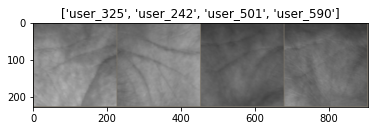

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=500):
    train_lss, val_lss, train_acc,val_acc = [], [], [], []
    since = time.time() #starting time

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #add to lists
            if phase == 'train':
              train_lss.append(float(epoch_loss))
              train_acc.append(float(epoch_acc))
            else:
              val_lss.append(float(epoch_loss))
              val_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_lss, val_lss, train_acc,val_acc

In [5]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00005)

# Decay LR by a factor of 0.1 every 100 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [6]:
model_ft, train_lss, val_lss, train_acc,val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 6.1931 Acc: 0.0478
val Loss: 5.3214 Acc: 0.1747

Epoch 1/499
----------
train Loss: 4.5309 Acc: 0.4918
val Loss: 3.9118 Acc: 0.5160

Epoch 2/499
----------
train Loss: 2.9332 Acc: 0.9115
val Loss: 2.5206 Acc: 0.7682

Epoch 3/499
----------
train Loss: 1.4856 Acc: 0.9923
val Loss: 1.4868 Acc: 0.8902

Epoch 4/499
----------
train Loss: 0.6195 Acc: 0.9987
val Loss: 0.9396 Acc: 0.9270

Epoch 5/499
----------
train Loss: 0.2531 Acc: 1.0000
val Loss: 0.6867 Acc: 0.9397

Epoch 6/499
----------
train Loss: 0.1201 Acc: 1.0000
val Loss: 0.5151 Acc: 0.9537

Epoch 7/499
----------
train Loss: 0.0628 Acc: 0.9997
val Loss: 0.4551 Acc: 0.9538

Epoch 8/499
----------
train Loss: 0.0344 Acc: 1.0000
val Loss: 0.3465 Acc: 0.9635

Epoch 9/499
----------
train Loss: 0.0256 Acc: 1.0000
val Loss: 0.3464 Acc: 0.9522

Epoch 10/499
----------
train Loss: 0.0228 Acc: 1.0000
val Loss: 0.2900 Acc: 0.9575

Epoch 11/499
----------
train Loss: 0.0123 Acc: 0.9998
val Loss: 0.2761 Acc

In [7]:
torch.save(model_ft.state_dict(), 'resnet18_tongji_unfreezed.pt')

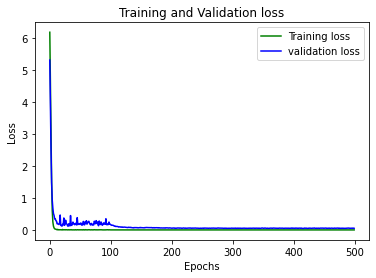

<Figure size 432x288 with 0 Axes>

In [8]:
epochs = range(0,500)
plt.plot(epochs, train_lss, 'g', label='Training loss')
plt.plot(epochs, val_lss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss.png')

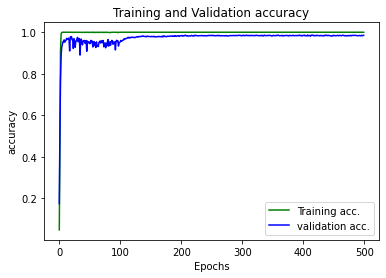

<Figure size 432x288 with 0 Axes>

In [9]:
epochs = range(0,500)
plt.plot(epochs, train_acc, 'g', label='Training acc.')
plt.plot(epochs, val_acc, 'b', label='validation acc.')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('acc.png')